# Day 2: PL/Python을 활용한 전복(abalone) 성숙 여부(mature) 분류

**Python Scikit-Learn의 (1) Logistic Regression, (2) Random Forest Classifier** 라이브러리를 이용하여  
**전복의 성숙(mature), 미성숙(immature) 여부를 판별하는 이진 분류(binary classification)** 하는 문제입니다.  
나이(age) = rings + 1.5 이며, 나이가 10살 이상이면 성숙(mature)으로 정의합니다. 

## 데이터셋(abalone.data) 소개

예제로 사용할 데이터셋은 __[UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data)__에 공개되어 있는 abalone.data.txt 파일입니다. 

### Attribute Information: 
----
** Name / Data Type / Measurement Unit / Description  **

Sex / nominal / -- / M, F, and I (infant)  
Length / continuous / mm / Longest shell measurement  
Diameter	/ continuous / mm / perpendicular to length  
Height / continuous / mm / with meat in shell  
Whole weight / continuous / grams / whole abalone  
Shucked weight / continuous	/ grams / weight of meat  
Viscera weight / continuous / grams / gut weight (after bleeding)  
Shell weight / continuous / grams / after being dried  
**Rings / integer / -- / +1.5 gives the age in years  **

---- 

## Notebook 환경 설정

In [1]:
import numpy as np
import pandas as pd
import math
import six
from sqlalchemy import create_engine # DB 연동

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# notebook 안에서 그래프 보기
%matplotlib inline

pd.set_option('display.max_columns', 200)

의사결정나무 시각화를 위해 Graphviz 오픈소스 설치가 필요합니다. Graphviz 설치에 문제가 있을 경우 https://www.graphviz.org/download/ 를 참고하세요. 

## GPDB 연결

- **dbconnect.py**는 GPDB에 연결하고, Jupyter Notebook에서 SQL을 사용할 수 있도록 해주는 __[SQL Magic](http://engineering.pivotal.io/post/introducing-sql-magic/)__을 쉽게 설정할 수 있도록 도와주는 custom module입니다. dbconnect.py 파일을 Jupyter Notebook이 실행되는 폴더에 넣고 아래의 import dbconnect를 실행시켜 주세요. </br>


- 아래처럼 GPDB의 host, port, user, database, password 정보가 입력된 **db_credentials.txt** 파일을 dbconnect.py 파일과 같은 폴더에 넣어주세요. 

> [database_creds]  
host: localhost  
port: 5432  
user: gpadmin  
database: gpadmin  
password: pivotal  

In [3]:
import dbconnect

In [4]:
db_credential_file = 'db_credentials.txt'
dbconnect.connect_and_register_sql_magic(
    db_credential_file, 
    conn_name='conn'
)

Connection object assigned to `conn`


## Abalone 데이터셋을 GPDB에 업로드 하기

- 한줄짜리 SQL이면 **%%read_sql**을 쓰고, 같은 줄에 SQL문을 써줍니다. 
- 두줄 이상의 SQL이면 **%%read_sql**을 먼저 써주고, 그 다음줄부터 SQL을 써주면 됩니다. 

In [5]:
schema = 'ds_training_plpy'

In [6]:
%read_sql DROP SCHEMA IF EXISTS {schema} CASCADE;
%read_sql CREATE SCHEMA {schema};

Query started at 10:06:37 PM KST; Query executed in 0.00 m

- Web에 있는 abalone 데이터셋을 External Table로 먼저 가져옵니다. 

In [7]:
%%read_sql
-- External Table
DROP EXTERNAL TABLE IF EXISTS {schema}.abalone_external;
CREATE EXTERNAL WEB TABLE {schema}.abalone_external(
    sex text 
    , length float8
    , diameter float8
    , height float8
    , whole_weight float8
    , shucked_weight float8
    , viscera_weight float8
    , shell_weight float8
    , rings integer -- target variable to predict
) location('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data') 
format 'CSV' 
(null as '?');

Query started at 10:06:37 PM KST; Query executed in 0.00 m

- External Table에서 데이터를 가져다가 GPDB에 abalone table을 생성합니다. 

In [8]:
%%read_sql
-- Create a table at Greenplum Database from external table
DROP TABLE IF EXISTS {schema}.abalone;
CREATE TABLE {schema}.abalone AS
    SELECT row_number() over() AS id, * 
    FROM {schema}.abalone_external
    DISTRIBUTED BY (sex);

Query started at 10:06:37 PM KST; Query executed in 0.02 m

In [9]:
%read_sql SELECT * FROM {schema}.abalone LIMIT 5;

Query started at 10:06:39 PM KST; Query executed in 0.00 m

,id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,1,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,4,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,5,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,6,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


## Target 변수 탐색 및 정의
- %%read_sql 다음에 -d 는 조회결과를 화면에 나타내지 말라는 것이며, 아래 예처럼 'df_abalone'를 써주면 pandas DataFrame을 만들어줍니다. 
- age = rings + 1.5

In [10]:
%%read_sql -d df_abalone
SELECT * FROM {schema}.abalone

Query started at 10:06:39 PM KST; Query executed in 0.00 m

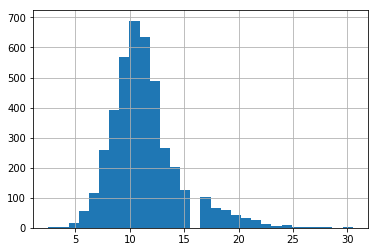

In [11]:
(df_abalone.rings + 1.5).hist(bins=30)

In [12]:
((df_abalone.rings + 1.5) >= 10).value_counts()

True     2770
False    1407
Name: rings, dtype: int64

In [13]:
_cumsum = (df_abalone.rings + 1.5).value_counts().sort_index().cumsum()
_cumsum / df_abalone.shape[0]

2.5     0.000239
3.5     0.000479
4.5     0.004070
5.5     0.017716
6.5     0.045248
7.5     0.107254
8.5     0.200862
9.5     0.336845
10.5    0.501796
11.5    0.653579
12.5    0.770170
13.5    0.834091
14.5    0.882691
15.5    0.912856
16.5    0.937515
17.5    0.953555
18.5    0.967441
19.5    0.977496
20.5    0.985157
21.5    0.991381
22.5    0.994733
23.5    0.996169
24.5    0.998324
25.5    0.998803
26.5    0.999042
27.5    0.999282
28.5    0.999761
30.5    1.000000
Name: rings, dtype: float64

- age = rings + 1.5
- target 변수 정의: 연령 10년 이상이면 성숙(mature), 10년 미만이면 미성숙(immature)
- 성별 코드(M, F, I)를 대문자에서 소문자로 변환

In [14]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_target;
CREATE TABLE {schema}.abalone_target AS 
    SELECT 
        id
        , lower(sex) as sex
        , length
        , diameter
        , height
        , whole_weight
        , shucked_weight
        , viscera_weight
        , shell_weight
        , rings
        , rings + 1.5 AS age
        , CASE WHEN (rings + 1.5) >= 10 THEN 1 ELSE 0 END AS mature
    FROM {schema}.abalone

Query started at 10:06:39 PM KST; Query executed in 0.00 m

In [15]:
%read_sql SELECT * FROM {schema}.abalone_target ORDER BY id LIMIT 5;

Query started at 10:06:39 PM KST; Query executed in 0.00 m

,id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature
0,1,m,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,1
1,2,m,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0
2,3,f,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,1
3,4,m,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,1
4,5,i,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0


In [16]:
%%read_sql 
SELECT count(*) AS total_cnt, sum(mature) AS mature_cnt, 100*sum(mature)/count(*) AS mature_ratio
FROM {schema}.abalone_target;

Query started at 10:06:40 PM KST; Query executed in 0.00 m

,total_cnt,mature_cnt,mature_ratio
0,4177,2770,66


## 탐색적 데이터 분석

- 요약 통계량: 빈도, 결측값, 평균, 분산, 95% 신뢰구간, 최소값, 최대값, 4분위수, 중앙값, 최빈값
- MADlib Summary Function: http://madlib.apache.org/docs/latest/group__grp__summary.html

In [17]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_summary CASCADE;
SELECT madlib.summary(
    '{schema}.abalone_target'    -- source table
    , '{schema}.abalone_summary' -- output table
    , 'sex, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature' -- target column
    , NULL                       -- grouping column
)

Query started at 10:06:40 PM KST; Query executed in 0.01 m

In [18]:
%read_sql SELECT * FROM {schema}.abalone_summary;

Query started at 10:06:41 PM KST; Query executed in 0.00 m

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,sex,2,text,4177,3,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.0000,1.0000,NaN,NaN,NaN,"[m, m, i, i, f, f]","[1528, 1528, 1342, 1342, 1307, 1307]"
1,None,None,length,3,float8,4177,134,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.523992,0.014422,"[0.520350088942874, 0.527634110243145]",0.0750,0.8150,0.4500,0.5450,0.615,"[0.625, 0.55, 0.625, 0.575, 0.575, 0.58, 0.58,...","[94, 94, 94, 93, 93, 92, 92, 87, 87, 87]"
2,None,None,diameter,4,float8,4177,111,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.407881,0.009849,"[0.404871645997761, 0.410890862979975]",0.0550,0.6500,0.3500,0.4250,0.480,"[0.45, 0.45, 0.475, 0.475, 0.4, 0.4, 0.5, 0.5,...","[139, 139, 120, 120, 111, 111, 110, 110, 100, ..."
3,None,None,height,5,float8,4177,51,0,NaN,0.0,NaN,4175.0,0.0,2.0,0.139516,0.001750,"[0.138247926591563, 0.140784872067762]",0.0000,1.1300,0.1150,0.1400,0.165,"[0.15, 0.15, 0.14, 0.14, 0.155, 0.155, 0.175, ...","[267, 267, 220, 220, 217, 217, 211, 211, 205, ..."
4,None,None,whole_weight,6,float8,4177,2429,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.828742,0.240481,"[0.813870324055099, 0.843613994834055]",0.0020,2.8255,0.4415,0.7995,1.153,"[1.1345, 0.2225, 0.4775, 0.3675, 1.1155, 0.874...","[11, 8, 7, 7, 7, 7, 7, 7, 7, 6]"
5,None,None,shucked_weight,7,float8,4177,1515,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.359367,0.049268,"[0.352636105342963, 0.366098871913442]",0.0010,1.4880,0.1860,0.3360,0.502,"[0.175, 0.2505, 0.0745, 0.2, 0.419, 0.21, 0.20...","[11, 10, 10, 9, 9, 9, 9, 9, 8, 8]"
6,None,None,viscera_weight,8,float8,4177,880,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.180594,0.012015,"[0.17726937948362, 0.183917836221431]",0.0005,0.7600,0.0935,0.1710,0.253,"[0.1715, 0.061, 0.0575, 0.037, 0.0265, 0.15, 0...","[15, 13, 13, 13, 12, 12, 12, 12, 11, 11]"
7,None,None,shell_weight,9,float8,4177,926,0,NaN,0.0,NaN,4177.0,0.0,0.0,0.238831,0.019377,"[0.234609314715373, 0.243052404221663]",0.0015,1.0050,0.1300,0.2340,0.329,"[0.275, 0.25, 0.315, 0.265, 0.265, 0.185, 0.28...","[43, 42, 40, 40, 40, 40, 37, 37, 37, 36]"
8,None,None,mature,12,int4,4177,2,0,NaN,0.0,NaN,2770.0,0.0,1407.0,0.663155,0.223434,"[0.648820355293342, 0.67749039404829]",0.0000,1.0000,0.0000,1.0000,1.000,"[1, 1, 0, 0]","[2770, 2770, 1407, 1407]"


> 결측값(missing value) 없음  
> 높이(height) '0'인 관측치 확인 필요

- abalone 데이터셋을 로컬 클라이언트 컴퓨터에서는 처리할 수 없는 매우 큰 크기의 데이터셋이라고 가정합시다. 
- 연속형 변수를 성별(sex) 기준 stratified random sampling하여 Python으로 히스토그램(histogram), 산점도 행렬(scatter plot matrix) 그려보겠습니다. 
- MADlib Stratified Random Sampling: http://madlib.apache.org/docs/latest/group__grp__strs.html

In [19]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_sample;
SELECT madlib.stratified_sample(
    '{schema}.abalone_target'   -- source table
    , '{schema}.abalone_sample' -- output table
    , 0.9                       -- sample proportion
    , 'sex'                     -- strata definition
    , 'length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature' -- columns to output
    , FALSE                     -- FALSE means 'sampling without replacement'
)

Query started at 10:06:41 PM KST; Query executed in 0.00 m

In [20]:
%%read_sql -d df_abalone_sample
SELECT * FROM {schema}.abalone_sample;

Query started at 10:06:41 PM KST; Query executed in 0.00 m

In [21]:
%%read_sql
SELECT sex, count(*) FROM {schema}.abalone_sample GROUP BY sex;

Query started at 10:06:41 PM KST; Query executed in 0.00 m

,sex,count
0,i,1208
1,m,1376
2,f,1177


- Python seaborn 라이브러리를 이용한 산점도 행렬(scatter plot matrix) 시각화

/Users/ihongdon/anaconda3/envs/py3.5_tf1.4/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


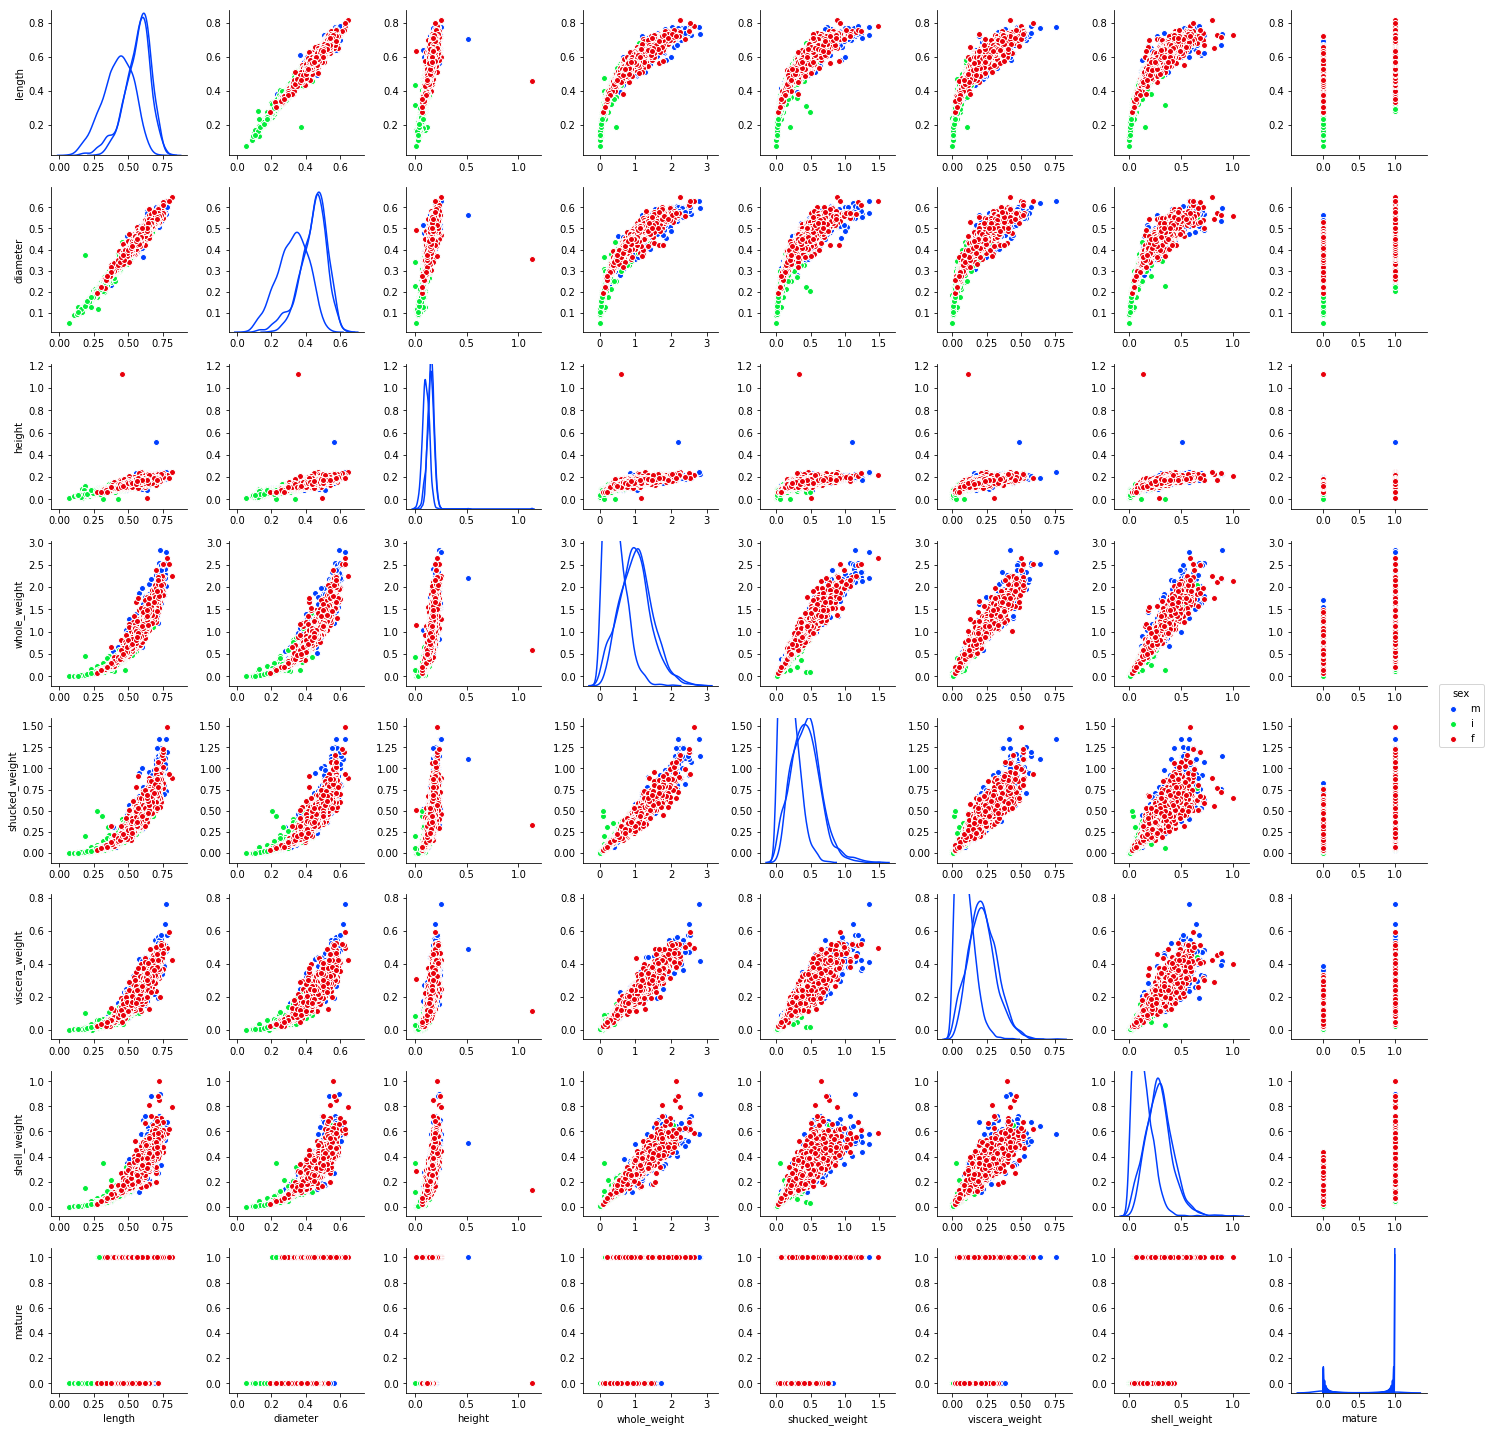

In [22]:
sns.pairplot(df_abalone_sample
            , diag_kind='kde'
            , hue='sex'
            , palette='bright')

> 성별 'I'와 'M', 'F' 간에 분포의 차이가 존재하고, 'M'과 'F' 간에는 분포 상 차이 거의 없어 보임  
  ==> **범주형 변수 one-hot encoding, 혹은 성별 모델링**  
  
> 독립변수들 간의 강한 상관관계 존재 (다중공선성 의심됨)   
  ==> **변수 제거, 혹은 차원 축소**

- 상관관계 분석 (correlation coefficients analysis)
- MADlib Correlation: http://madlib.apache.org/docs/latest/group__grp__correlation.html

In [23]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_correlation, {schema}.abalone_correlation_summary;
SELECT madlib.correlation(
    '{schema}.abalone_target'        -- source table
    , '{schema}.abalone_correlation' -- output table
    , 'length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature' -- target columns
    , TRUE                           -- verbose
    , 'sex'                          -- grouping column
)

Query started at 10:06:51 PM KST; Query executed in 0.01 m

In [24]:
%%read_sql df_abalone_correlation
SELECT sex, variable, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, mature
FROM {schema}.abalone_correlation 
ORDER BY sex, column_position;

Query started at 10:06:52 PM KST; Query executed in 0.00 m

,sex,variable,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,mature
0,f,length,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f,diameter,0.971081,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,f,height,0.553494,0.562149,1.000000,NaN,NaN,NaN,NaN,NaN
3,f,whole_weight,0.929116,0.925641,0.583747,1.000000,NaN,NaN,NaN,NaN
4,f,shucked_weight,0.892259,0.878953,0.531077,0.949567,1.000000,NaN,NaN,NaN
5,f,viscera_weight,0.890732,0.878164,0.550720,0.939944,0.890135,1.000000,NaN,NaN
6,f,shell_weight,0.864876,0.876235,0.580622,0.923708,0.801906,0.839690,1.000000,NaN
7,f,mature,0.325125,0.339494,0.202458,0.304832,0.237307,0.296193,0.338859,1.0
8,i,length,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,i,diameter,0.986113,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


- 상관계수 Heatmap

In [25]:
df_abalone_correlation.style.background_gradient(cmap='summer')

/Users/ihongdon/anaconda3/envs/py3.5_tf1.4/lib/python3.5/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,sex,variable,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,mature
0,f,length,1,nan,nan,nan,nan,nan,nan,nan
1,f,diameter,0.971081,1,nan,nan,nan,nan,nan,nan
2,f,height,0.553494,0.562149,1,nan,nan,nan,nan,nan
3,f,whole_weight,0.929116,0.925641,0.583747,1,nan,nan,nan,nan
4,f,shucked_weight,0.892259,0.878953,0.531077,0.949567,1,nan,nan,nan
5,f,viscera_weight,0.890732,0.878164,0.55072,0.939944,0.890135,1,nan,nan
6,f,shell_weight,0.864876,0.876235,0.580622,0.923708,0.801906,0.83969,1,nan
7,f,mature,0.325125,0.339494,0.202458,0.304832,0.237307,0.296193,0.338859,1
8,i,length,1,nan,nan,nan,nan,nan,nan,nan
9,i,diameter,0.986113,1,nan,nan,nan,nan,nan,nan


> 독립변수들 간의 강한 상관관계 존재 (다중공선성 의심됨)   
  ==> **변수 제거, 혹은 차원 축소**  
> 성별 'I'의 성숙도와 설명변수들과 강한 상관관계를 보임 (상관계수 0.5~0.6보다 큼).  
> 반면, 성별 'F', 'M'의 성숙도와 설명변수들과는 상대적으로 약한 상관관계를 보임 (상관계수 0.2~0.5 사이).  
  ==> **성(sex)별 개별 모델 개발**  

- 분산팽창지수(VIF, Variance Inflation Factor)를 통한 다중공선성(Multicollinearity) 여부 확인
- 기준: VIF가 작으면 작을 수록 좋음. VIF 지수가 10 이상이면 다중공선성이 매우 의심되므로 제거하는게 좋음

In [26]:
df_abalone_sample.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,mature
0,m,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
1,m,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,1
2,i,0.380,0.275,0.100,0.2255,0.0800,0.0490,0.085,1
3,m,0.580,0.470,0.165,0.9975,0.3935,0.2420,0.330,1
4,i,0.240,0.175,0.045,0.0700,0.0315,0.0235,0.020,0


In [27]:
def vif_func(df, y, X_list):
    from patsy import dmatrices
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    features = "+".join(X_list)
    y, X = dmatrices('mature'+ '~' + features, df_abalone_sample, return_type='dataframe')
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

In [28]:
vif_func(df_abalone_sample, 'mature', ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'])

/Users/ihongdon/anaconda3/envs/py3.5_tf1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,VIF Factor,features
0,60.614886,Intercept
1,40.281245,length
2,41.469973,diameter
3,3.413733,height
4,108.836936,whole_weight
5,28.007355,shucked_weight
6,17.652627,viscera_weight
7,21.159914,shell_weight


In [29]:
# removed 'whole_weight'
vif_func(df_abalone_sample, 'mature', ['length', 'diameter', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight'])

,VIF Factor,features
0,60.427282,Intercept
1,40.278034,length
2,41.450630,diameter
3,3.412063,height
4,8.922920,shucked_weight
5,10.921507,viscera_weight
6,7.870550,shell_weight


In [30]:
# removed 'diameter'
vif_func(df_abalone_sample, 'mature', ['length', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight'])

,VIF Factor,features
0,60.426946,Intercept
1,7.900690,length
2,3.367770,height
3,8.921165,shucked_weight
4,10.911116,viscera_weight
5,7.502573,shell_weight


In [31]:
# removed 'viscera_weight'
vif_func(df_abalone_sample, 'mature', ['length', 'height', 'shucked_weight', 'shell_weight'])

,VIF Factor,features
0,58.015046,Intercept
1,7.652079,length
2,3.350488,height
3,6.114383,shucked_weight
4,6.558836,shell_weight


- 다중공선성이 있는 'whole_weight', 'diameter', 'viscera_weight' 칼럼은 제거한 테이블 생성

In [32]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_vif_rmv CASCADE;
CREATE TABLE {schema}.abalone_vif_rmv AS
    SELECT id, sex, length, height, shucked_weight, shell_weight, rings, age, mature -- removed 'whole_weight', 'diameter', 'viscera_weight' 
    FROM {schema}.abalone_target;

Query started at 10:06:52 PM KST; Query executed in 0.00 m

## Training Set, Test Set 분할
- Training Set: 모델 훈련용, 80%, 반복재추출 없음
- Test Set: 모델 평가용, 20%, 반복재추출 없음
- MADlib Train-Test Split: http://madlib.apache.org/docs/latest/group__grp__train__test__split.html

In [33]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_classif CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_classif_train CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_classif_test CASCADE;
SELECT madlib.train_test_split(
    '{schema}.abalone_vif_rmv' -- source table
    , '{schema}.abalone_classif' -- output table
    , 0.8                      -- train_proportion
    , 0.2                      -- test_proportion
    , 'sex'                    -- strata definition
    , 'id, length, height, shucked_weight, shell_weight, mature' -- columns to output
    , FALSE                    -- sampling without replacement
    , TRUE                     -- separate output tables
);

Query started at 10:06:53 PM KST; Query executed in 0.01 m

In [34]:
%read_sql SELECT mature, count(*) FROM {schema}.abalone_classif_train GROUP BY mature;

Query started at 10:06:53 PM KST; Query executed in 0.00 m

,mature,count
0,1,2206
1,0,1134


In [35]:
%read_sql SELECT mature, count(*) FROM {schema}.abalone_classif_test GROUP BY mature;

Query started at 10:06:53 PM KST; Query executed in 0.00 m

,mature,count
0,0,273
1,1,564


In [36]:
%read_sql SELECT * FROM {schema}.abalone_classif_train LIMIT 5;

Query started at 10:06:53 PM KST; Query executed in 0.00 m

,sex,id,length,height,shucked_weight,shell_weight,mature
0,f,15,0.470,0.100,0.1675,0.185,1
1,f,25,0.615,0.165,0.5130,0.305,1
2,f,41,0.450,0.105,0.1865,0.115,1
3,f,54,0.470,0.120,0.2105,0.150,1
4,f,60,0.505,0.125,0.2460,0.175,0


In [37]:
%read_sql SELECT * FROM {schema}.abalone_classif_test LIMIT 5;

Query started at 10:06:53 PM KST; Query executed in 0.00 m

,sex,id,length,height,shucked_weight,shell_weight,mature
0,m,92,0.555,0.150,0.3070,0.2600,1
1,m,191,0.615,0.180,0.4845,0.3250,1
2,m,202,0.500,0.165,0.2540,0.2850,1
3,m,268,0.350,0.110,0.1225,0.0905,0
4,m,361,0.605,0.180,0.4800,0.3500,1


## PL/Python - (1) Logistic Regression
- **성(sex) 그룹별 개별 모델 개발**  

### 데이터를 하나의 Cell에 합치기 (aggregate into a single cell)
- ARRAY를 합치기 위한 사용자 정의 함수 정의

In [38]:
%%read_sql
CREATE OR REPLACE FUNCTION {schema}.array_append_2d(integer[][], integer[])
    RETURNS integer[][]
    LANGUAGE SQL
    AS 'select array_cat($1, ARRAY[$2])'
    IMMUTABLE
;
CREATE OR REPLACE FUNCTION {schema}.array_append_2d(numeric[][], numeric[])
    RETURNS numeric[][]
    LANGUAGE SQL
    AS 'select array_cat($1, ARRAY[$2])'
    IMMUTABLE
;
CREATE OR REPLACE FUNCTION {schema}.array_append_2d(double precision[][], double precision[])
    RETURNS double precision[][]
    LANGUAGE SQL
    AS 'select array_cat($1, ARRAY[$2])'
    IMMUTABLE
;

Query started at 10:06:53 PM KST; Query executed in 0.00 m

In [39]:
%%read_sql
DROP AGGREGATE IF EXISTS {schema}.array_agg_array(double precision[]) CASCADE;
CREATE ORDERED AGGREGATE {schema}.array_agg_array(double precision[])
(
    SFUNC = {schema}.array_append_2d
    , STYPE = double precision[][]
);

Query started at 10:06:54 PM KST; Query executed in 0.00 m

In [40]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_train_agg CASCADE;
CREATE TABLE {schema}.abalone_train_agg AS (
    SELECT 
        sex
        , {schema}.array_agg_array(feature_vec ORDER BY id) AS feature_arr
        , array_agg(mature ORDER BY id) AS y_arr
    FROM (
        SELECT 
            id
            , sex
            , mature
            , ARRAY[
                length
                , height
                , shucked_weight
                , shell_weight
            ] AS feature_vec
        FROM {schema}.abalone_classif_train
    ) tmp
    GROUP BY sex
);

Query started at 10:06:54 PM KST; Query executed in 0.00 m

In [41]:
%%read_sql
SELECT * FROM {schema}.abalone_train_agg;

Query started at 10:06:54 PM KST; Query executed in 0.00 m

,sex,feature_arr,y_arr
0,f,"[[0.53, 0.15, 0.237, 0.33], [0.545, 0.125, 0.2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,i,"[[0.425, 0.095, 0.141, 0.12], [0.355, 0.085, 0...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,m,"[[0.455, 0.095, 0.2245, 0.15], [0.35, 0.09, 0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ..."


### Python sklearn 활용한 Logistic Regression 사용자 정의 함수 생성

In [42]:
%%read_sql
DROP FUNCTION IF EXISTS {schema}.logregr_train(features float[][], targets integer[]);
CREATE OR REPLACE FUNCTION {schema}.logregr_train(features float[][], targets integer[])
RETURNS bytea
AS
$$
def logregr_train(features, targets):
    """
    Training function for Logistic Regression using Python Scikit-Learn Library
    
    Inputs
    - features: 2-dimensional array or list-of-lists
    - targets: 1-dimensional array or list
    
    Returns
    - serialized model as a string
    """
    from sklearn.linear_model import LogisticRegression
    
    import six
    pickle = six.moves.cPickle
    
    logregr = LogisticRegression(solver='lbfgs')
    logregr.fit(features, targets)
    
    return pickle.dumps(logregr, protocol=2)

return logregr_train(features, targets)
$$ LANGUAGE plpythonu;

Query started at 10:06:54 PM KST; Query executed in 0.00 m

### 성(sex) 그룹별 Logistic Regression Model을 In-Database에서 병렬로 훈련

In [43]:
%%read_sql
DROP TABLE IF EXISTS {schema}.logregr_model CASCADE;
CREATE TABLE {schema}.logregr_model AS 
    (
    SELECT 
        sex
        , {schema}.logregr_train(feature_arr, y_arr) AS model
        , now() AS serialized_on
    FROM {schema}.abalone_train_agg
        GROUP BY sex, model
    );

Query started at 10:06:54 PM KST; Query executed in 0.01 m

In [44]:
%%read_sql df_logregr_model
SELECT 
    sex
    , serialized_on
    , length(model)
    , model::text
FROM {schema}.logregr_model;

Query started at 10:06:55 PM KST; Query executed in 0.00 m

,sex,serialized_on,length,model
0,f,2019-03-19 13:06:54.646288+00:00,704,\200\002csklearn.linear_model.logistic\012Logi...
1,m,2019-03-19 13:06:54.646288+00:00,704,\200\002csklearn.linear_model.logistic\012Logi...
2,i,2019-03-19 13:06:54.646288+00:00,704,\200\002csklearn.linear_model.logistic\012Logi...


In [45]:
df_logregr_model.model.iloc[0]

'\\200\\002csklearn.linear_model.logistic\\012LogisticRegression\\012q\\001)\\201q\\002}q\\003(U\\012warm_startq\\004\\211U\\001CG?\\360\\000\\000\\000\\000\\000\\000U\\006n_jobsq\\005K\\001U\\007verboseq\\006K\\000U\\015fit_interceptq\\007\\210U\\006solverq\\010U\\005lbfgsq\\011U\\010classes_q\\012cnumpy.core.multiarray\\012_reconstruct\\012q\\013cnumpy\\012ndarray\\012q\\014K\\000\\205U\\001b\\207Rq\\015(K\\001K\\002\\205cnumpy\\012dtype\\012q\\016U\\002i8K\\000K\\001\\207Rq\\017(K\\003U\\001<NNNJ\\377\\377\\377\\377J\\377\\377\\377\\377K\\000tb\\211U\\020\\000\\000\\000\\000\\000\\000\\000\\000\\001\\000\\000\\000\\000\\000\\000\\000tbU\\007n_iter_q\\020h\\013h\\014K\\000\\205U\\001b\\207Rq\\021(K\\001K\\001\\205h\\016U\\002i4K\\000K\\001\\207Rq\\022(K\\003U\\001<NNNJ\\377\\377\\377\\377J\\377\\377\\377\\377K\\000tb\\211U\\004\\031\\000\\000\\000tbU\\021intercept_scalingq\\023K\\001U\\007penaltyq\\024U\\002l2q\\025U\\013multi_classq\\026U\\003ovrq\\027U\\014random_stateq\\030NU\\020

### 학습된 PL/Python Logistic Regression 모형 정보 알아보기

In [46]:
%%read_sql
DROP TYPE IF EXISTS {schema}.logregr_info_type CASCADE;
CREATE TYPE {schema}.logregr_info_type AS
    (
        classes text[]
        , coefficients text  -- float[]
        , intercept float[]  -- float
        , num_iteration integer[] -- integer
    );
    
CREATE OR REPLACE FUNCTION {schema}.get_logregr_info(serialized_model bytea) 
RETURNS {schema}.logregr_info_type
AS
$$
    import six
    pickle = six.moves.cPickle

    model = pickle.loads(serialized_model)

    return [
        model.classes_
        , model.coef_
        , model.intercept_
        , model.n_iter_
    ]
$$ LANGUAGE plpythonu;

Query started at 10:06:55 PM KST; Query executed in 0.00 m

In [47]:
%%read_sql df_logregr_info
SELECT
    sex
    , serialized_on
    , ({schema}.get_logregr_info(model)).*
FROM {schema}.logregr_model;

Query started at 10:06:55 PM KST; Query executed in 0.01 m

,sex,serialized_on,classes,coefficients,intercept,num_iteration
0,i,2019-03-19 13:06:54.646288+00:00,"[0, 1]",[[4.68116309 2.08029988 3.39862849 5.41907203]],[-4.67472529049597],[24]
1,f,2019-03-19 13:06:54.646288+00:00,"[0, 1]",[[1.85577066 0.34773593 0.62181754 4.05872651]],[-0.637616035036213],[25]
2,m,2019-03-19 13:06:54.646288+00:00,"[0, 1]",[[2.40298441 1.29417537 0.64001324 5.72066943]],[-1.68321887849787],[20]


### PL/Python Logistic Regression 모델을 사용하여 In-Database에서 스코어링
- 스코어링 사용자 정의 함수 생성

In [48]:
%%read_sql
DROP FUNCTION IF EXISTS {schema}.sklearn_predict_1(serialized_model bytea, features float[]);
CREATE OR REPLACE FUNCTION {schema}.sklearn_predict_1(serialized_model bytea, features float[]) 
RETURNS float
LANGUAGE plpythonu
AS
$$
def sklearn_predict_1(serialized_model, features):
    """
    Predict a single record
    
    Input
    - serialzied_model: string
    - features: 1-dimensional array/list
    
    Returns: float
    """
    # make sure that features is only 1-dimensional
    assert not hasattr(features[0], '__len__')
    
    import six
    pickle = six.moves.cPickle
    
    model = pickle.loads(serialized_model)
    
    result = model.predict_proba([features])
    # 'result' is a 1x2 matrix
    # The second column shows probability of the true class, 
    # which is what we want to return
    return result[0, 1]

return sklearn_predict_1(serialized_model, features)
$$;

Query started at 10:06:55 PM KST; Query executed in 0.00 m

- Cross join model with table to be scored

In [49]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_proba;
CREATE TABLE {schema}.abalone_logregr_test_proba 
AS 
SELECT 
    test.id
    , test.sex
    , test.mature
    , {schema}.sklearn_predict_1(
        model_table.model
        , ARRAY[
            length
            , height
            , shucked_weight
            , shell_weight
        ]
    ) AS proba
FROM
    {schema}.abalone_classif_test AS test
    , {schema}.logregr_model AS model_table
WHERE test.sex = model_table.sex;

Query started at 10:06:55 PM KST; Query executed in 0.00 m

In [50]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_test_proba ORDER BY id LIMIT 10;

Query started at 10:06:55 PM KST; Query executed in 0.00 m

,id,sex,mature,proba
0,3,f,1,0.802931
1,4,m,1,0.636567
2,5,i,0,0.086172
3,10,f,1,0.873202
4,13,m,1,0.709939
5,16,m,1,0.772872
6,19,m,0,0.482895
7,34,f,1,0.954291
8,35,f,1,0.957817
9,42,f,1,0.852073


- AUC (Area Under the Curve)

In [51]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_auc CASCADE;
SELECT madlib.area_under_roc(
    '{schema}.abalone_logregr_test_proba' -- source table
    , '{schema}.abalone_logregr_test_auc' -- output table
    , 'proba'                             -- prediction column
    , 'mature'                            -- observed column
);

Query started at 10:06:56 PM KST; Query executed in 0.00 m

In [52]:
%%read_sql
SELECT * FROM {schema}.abalone_logregr_test_auc;

Query started at 10:06:56 PM KST; Query executed in 0.00 m

,area_under_roc
0,0.888558


- Confusion Matrix

In [53]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_predict CASCADE;
CREATE TABLE {schema}.abalone_logregr_test_predict AS 
    SELECT 
        (proba >= 0.5)::integer AS predicted
        , mature
    FROM {schema}.abalone_logregr_test_proba;

Query started at 10:06:56 PM KST; Query executed in 0.00 m

In [54]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_conf_matrix CASCADE;
SELECT madlib.confusion_matrix(
    '{schema}.abalone_logregr_test_predict'       -- source table
    , '{schema}.abalone_logregr_test_conf_matrix' -- output table
    , 'predicted'                                 -- prediction column
    , 'mature'                                    -- observation column
);

Query started at 10:06:56 PM KST; Query executed in 0.00 m

In [55]:
%%read_sql
SELECT class, confusion_arr[1] AS predicted_0, confusion_arr[2] AS predicted_1
    FROM {schema}.abalone_logregr_test_conf_matrix
    ORDER BY class;

Query started at 10:06:56 PM KST; Query executed in 0.00 m

,class,predicted_0,predicted_1
0,0,186.0,87.0
1,1,47.0,517.0


- ROC Curve

In [56]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_logregr_test_binary_metrics CASCADE;
SELECT madlib.binary_classifier(
    '{schema}.abalone_logregr_test_proba'            -- source table
    , '{schema}.abalone_logregr_test_binary_metrics' -- output table
    , 'proba'                                        -- prediction column
    , 'mature'                                       -- observation column
);

Query started at 10:06:56 PM KST; Query executed in 0.00 m

In [57]:
%%read_sql -d logregr_metrics
SELECT * 
    FROM {schema}.abalone_logregr_test_binary_metrics
    ORDER BY threshold;

Query started at 10:06:56 PM KST; Query executed in 0.00 m

In [58]:
def roc_curve_plot(fpr, tpr):
    plt.plot(fpr, tpr, marker='o', color='b')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.show()

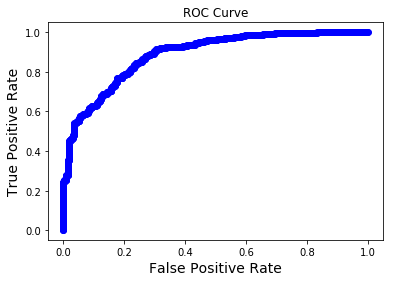

In [59]:
fpr = logregr_metrics.fpr
tpr = logregr_metrics.tpr

roc_curve_plot(fpr, tpr)

## PL/Python - (2) Random Forest Classifier

### Random Forest 사용자 정의 함수 생성

In [60]:
%%read_sql
DROP FUNCTION IF EXISTS {schema}.rf_train(features float[][], targets integer[]);
CREATE OR REPLACE FUNCTION {schema}.rf_train(features float[][], targets integer[])
RETURNS bytea
AS
$$
    def rf_train(features, targets):
        """
        Training function for Random Forest

        Inputs
        - features: 2-dimensional array or list-of-lists
        - targets: 1-dimensional array or list

        Returns: serialized model as a string
        """
        from sklearn.ensemble import RandomForestClassifier

        import six
        pickle = six.moves.cPickle

        model = RandomForestClassifier()
        model.fit(features, targets)

        return pickle.dumps(model, protocol=2)

    return rf_train(features, targets)
$$
LANGUAGE plpythonu;

Query started at 10:06:57 PM KST; Query executed in 0.00 m

### PL/Python Random Forest 모델을 In-Database에서 training

In [61]:
%%read_sql
DROP TABLE IF EXISTS {schema}.rf_model CASCADE;
CREATE TABLE {schema}.rf_model AS 
    SELECT 
        sex
        , {schema}.rf_train(feature_arr, y_arr) AS model
        , now() AS serialized_on
        FROM {schema}.abalone_train_agg
            GROUP BY sex, model;

Query started at 10:06:57 PM KST; Query executed in 0.01 m

In [62]:
%%read_sql df_rf_model
SELECT 
    sex
    , serialized_on
    , length(model)
    , model::text
    FROM {schema}.rf_model;

Query started at 10:06:57 PM KST; Query executed in 0.00 m

,sex,serialized_on,length,model
0,i,2019-03-19 13:06:57.381155+00:00,209907,\200\002csklearn.ensemble.forest\012RandomFore...
1,f,2019-03-19 13:06:57.381155+00:00,182670,\200\002csklearn.ensemble.forest\012RandomFore...
2,m,2019-03-19 13:06:57.381155+00:00,215955,\200\002csklearn.ensemble.forest\012RandomFore...


### Random Forest Model 정보 얻기

In [63]:
%%read_sql
DROP TYPE IF EXISTS {schema}.rf_info CASCADE;
CREATE TYPE {schema}.rf_info AS 
    (
        classes text[]
        , max_depth integer
        , n_estimators integer
        , feature_importances float[]
    )
;

Query started at 10:06:58 PM KST; Query executed in 0.00 m

In [64]:
%%read_sql
CREATE OR REPLACE FUNCTION {schema}.get_rf_info(serialized_model bytea)
RETURNS {schema}.rf_info
AS
$$
    import six
    pickle = six.moves.cPickle

    model = pickle.loads(serialized_model)

    return [
        model.classes_
        , model.max_depth
        , model.n_estimators
        , model.feature_importances_
    ]
$$ LANGUAGE plpythonu;

Query started at 10:06:58 PM KST; Query executed in 0.00 m

In [65]:
%%read_sql df_rf_info
SELECT 
    sex
    , serialized_on
    , ({schema}.get_rf_info(model)).*
FROM {schema}.rf_model;

Query started at 10:06:58 PM KST; Query executed in 0.00 m

,sex,serialized_on,classes,max_depth,n_estimators,feature_importances
0,i,2019-03-19 13:06:57.381155+00:00,"[0, 1]",None,10,"[0.218535443443819, 0.222423521977185, 0.17174..."
1,f,2019-03-19 13:06:57.381155+00:00,"[0, 1]",None,10,"[0.200510367937407, 0.143332760126333, 0.30465..."
2,m,2019-03-19 13:06:57.381155+00:00,"[0, 1]",None,10,"[0.242566539902911, 0.123832723975099, 0.26487..."


In [66]:
feature_importance = pd.DataFrame({
    'feature' : ['length', 'height', 'shucked_weight', 'shell_weight'], 
    'feature_importance_i': df_rf_info.feature_importances[0],
    'feature_importance_f': df_rf_info.feature_importances[1],
    'feature_importance_m': df_rf_info.feature_importances[2]});

feature_importance

,feature,feature_importance_f,feature_importance_i,feature_importance_m
0,length,0.200510,0.218535,0.242567
1,height,0.143333,0.222424,0.123833
2,shucked_weight,0.304660,0.171747,0.264871
3,shell_weight,0.351497,0.387294,0.368730


### PL/Python Random Forest모델로 Test set에 대해 성능 평가

In [67]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_test_proba CASCADE;
CREATE TABLE {schema}.abalone_rf_test_proba AS 
    SELECT 
        test.id
        , test.sex
        , test.mature
        , {schema}.sklearn_predict_1(
            model_table.model
            , ARRAY[
                length
                , height
                , shucked_weight
                , shell_weight
            ]
        ) AS proba
    FROM 
        {schema}.abalone_classif_test AS test
        , {schema}.rf_model AS model_table
    WHERE test.sex = model_table.sex;

Query started at 10:06:58 PM KST; Query executed in 0.02 m

In [68]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_proba LIMIT 10;

Query started at 10:06:59 PM KST; Query executed in 0.00 m

,id,sex,mature,proba
0,3981,f,0,0.4
1,3841,f,1,0.9
2,3733,f,1,0.7
3,3454,f,0,0.8
4,3153,f,1,0.4
5,3083,f,1,1.0
6,4113,f,1,0.8
7,3883,f,1,1.0
8,3823,f,1,0.9
9,3704,f,1,1.0


In [69]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_test_predict;
CREATE TABLE {schema}.abalone_rf_test_predict AS 
    SELECT 
        test.id
        , test.sex
        , prob.proba
        , (prob.proba >= 0.5)::integer AS predicted_class
        , test.mature AS actual_class
    FROM {schema}.abalone_rf_test_proba prob
    INNER JOIN {schema}.abalone_classif_test test 
    ON prob.id = test.id;

Query started at 10:06:59 PM KST; Query executed in 0.00 m

In [70]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_predict LIMIT 10;

Query started at 10:06:59 PM KST; Query executed in 0.00 m

,id,sex,proba,predicted_class,actual_class
0,4075,i,0.3,0,0
1,4130,i,0.9,1,1
2,3688,i,1.0,1,1
3,3645,i,0.2,0,0
4,3748,i,0.1,0,0
5,3602,i,0.0,0,0
6,3541,i,0.2,0,0
7,3529,i,0.0,0,0
8,4152,i,0.0,0,0
9,4083,i,0.9,1,1


- **Confusion Matrix**

In [71]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_conf_matrix CASCADE;
SELECT madlib.confusion_matrix(
    '{schema}.abalone_rf_test_predict'       -- source table
    , '{schema}.abalone_rf_test_conf_matrix' -- output table
    , 'predicted_class'                      -- predicted column
    , 'actual_class'                         -- observed column
);

Query started at 10:06:59 PM KST; Query executed in 0.00 m

In [72]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_conf_matrix;

Query started at 10:07:00 PM KST; Query executed in 0.00 m

,row_id,class,confusion_arr
0,2,1,"[58, 506]"
1,1,0,"[192, 81]"


In [73]:
%%read_sql
SELECT class
    , confusion_arr[1] AS predicted_0
    , confusion_arr[2] AS predicted_1
    FROM {schema}.abalone_rf_test_conf_matrix
    ORDER BY class;

Query started at 10:07:00 PM KST; Query executed in 0.00 m

,class,predicted_0,predicted_1
0,0,192.0,81.0
1,1,58.0,506.0


- **ROC Curve**

In [74]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_binary_metrics;
SELECT madlib.binary_classifier(
    '{schema}.abalone_rf_test_predict'          -- source table
    , '{schema}.abalone_rf_test_binary_metrics' -- output table
    , 'proba'                        -- predicted_class
    , 'actual_class'                            -- actual_class
);

Query started at 10:07:00 PM KST; Query executed in 0.00 m

In [75]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_binary_metrics ORDER BY threshold LIMIT 5;

Query started at 10:07:00 PM KST; Query executed in 0.00 m

,threshold,tp,fp,fn,tn,tpr,tnr,ppv,npv,fpr,fdr,fnr,acc,f1
0,0.0,564.0,273.0,0.0,0.0,1.000000,0.000000,0.673835,NaN,1.000000,0.326165,0.000000,0.673835,0.805139
1,0.1,553.0,168.0,11.0,105.0,0.980496,0.384615,0.766990,0.905172,0.615385,0.233010,0.019504,0.786141,0.860700
2,0.2,548.0,142.0,16.0,131.0,0.971631,0.479853,0.794203,0.891156,0.520147,0.205797,0.028369,0.811231,0.874003
3,0.3,542.0,119.0,22.0,154.0,0.960993,0.564103,0.819970,0.875000,0.435897,0.180030,0.039007,0.831541,0.884898
4,0.4,527.0,98.0,37.0,175.0,0.934397,0.641026,0.843200,0.825472,0.358974,0.156800,0.065603,0.838710,0.886459


In [76]:
%%read_sql -d df_rf_metrics
SELECT fpr, tpr FROM {schema}.abalone_rf_test_binary_metrics ORDER BY threshold;

Query started at 10:07:00 PM KST; Query executed in 0.00 m

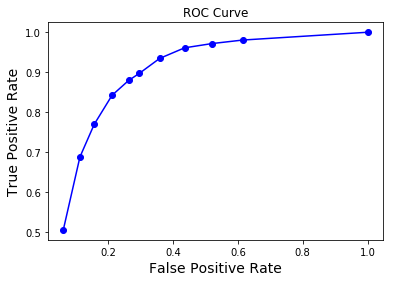

In [77]:
fpr_rf = df_rf_metrics.fpr
tpr_rf = df_rf_metrics.tpr

roc_curve_plot(fpr_rf, tpr_rf)

- ** AUC (Area Under the Curve) **

In [78]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_auc CASCADE;
SELECT madlib.area_under_roc(
    '{schema}.abalone_rf_test_predict' -- source table
    , '{schema}.abalone_rf_test_auc'   -- output table
    , 'proba'               -- predicted col
    , 'actual_class'                   -- observed col
);

Query started at 10:07:03 PM KST; Query executed in 0.00 m

In [79]:
%%read_sql
SELECT * FROM {schema}.abalone_rf_test_auc;

Query started at 10:07:03 PM KST; Query executed in 0.00 m

,area_under_roc
0,0.881228


 -- THE END --